In [330]:
# Bokeh streaming Stock prices
# https://zduey.github.io/snippets/streaming-stock-data-with-bokeh/
import pandas as pd
import numpy as np
import uuid
%matplotlib inline
import bokeh
import matplotlib as plt
plt.style.use('ggplot')

# set the settingWithCopyWarning in Pandas to None
pd.options.mode.chained_assignment = None  # default='warn'

In [331]:
all_user_data_df = pd.DataFrame.from_csv('generating_user_behavioral_data.csv')
all_user_data_df.head()

,device_uuid,date,feature1,feature2,feature3,platform,user_registered,country
0,512ff3c3-fa27-442d-a116-126ec5e46d0b,2016-09-01,2,1.6,1.2,Android,False,AU
1,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2016-10-01,3,2.4,1.8,Android,False,AU
2,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2016-11-01,10,8.0,6.0,Android,False,AU
3,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2016-12-01,2,1.6,1.2,Android,False,AU
4,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2017-01-01,10,8.0,6.0,Android,False,AU


## 1. Segmenting users

In [332]:
def segmenting(df, country, platform, registered):
    
    df['Date'] = pd.to_datetime(df['date'])
    # to_month = lambda x: x.strftime('%Y-%m')
    # df['Month'] = df['Month'].apply(to_month)

    # for each categorical (segmentation) feature
    if country != 'All countries':
        df = df[df['country'] == country]
        
    if platform != 'All platforms':
        df = df[df['platform'] == platform]
        
    if registered != 'True and False':
        df = df[df['user_registered'] == registered]
        
    return df

In [333]:
country_values = ['All countries'] + list(all_user_data_df['country'].unique())

platform_values = ['All platforms'] + list(all_user_data_df['platform'].unique())

user_registered_values = ['True and False'] + list(all_user_data_df['user_registered'].unique())

In [334]:
user_registered_values

['True and False', False, True]

In [335]:
# country, platform, registered
country_example = country_values[0]
df = segmenting(all_user_data_df.copy(), country='NL', platform='Android', registered=True)

## 2. Building cohorts

In [336]:
def preprocess_cohorting(df):
    df['sum'] = df['feature1'] + df['feature2'] + df['feature3']
    df['date'] = pd.to_datetime(df['date'])
    
    to_month = lambda x: x.strftime('%Y-%m')
    df['onboarded_period'] = df['date'].apply(to_month)
    
    df.set_index('device_uuid', inplace=True)
    df['cohort_group'] = df.groupby(level=0)['date'].min().apply(lambda x:  x.strftime('%Y-%m'))
    df.reset_index(inplace=True)
    
    return df

In [337]:
# step 1
df = preprocess_cohorting(df)
df.head()

,device_uuid,date,feature1,feature2,feature3,platform,user_registered,country,Date,sum,onboarded_period,cohort_group
0,255d8c88-717b-4afe-bcb1-39bc988babc7,2016-04-01,5,4.0,3.0,Android,True,NL,2016-04-01,12.0,2016-04,2016-04
1,17fcaa9f-e087-48e7-a894-dcee7a8dfe03,2016-05-01,1,0.8,0.6,Android,True,NL,2016-05-01,2.4,2016-05,2016-05
2,3281a5d4-0123-45f2-999b-6a245c5e7dea,2016-06-01,13,10.4,7.8,Android,True,NL,2016-06-01,31.2,2016-06,2016-06
3,3281a5d4-0123-45f2-999b-6a245c5e7dea,2016-07-01,6,4.8,3.6,Android,True,NL,2016-07-01,14.4,2016-07,2016-06
4,3281a5d4-0123-45f2-999b-6a245c5e7dea,2016-08-01,3,2.4,1.8,Android,True,NL,2016-08-01,7.2,2016-08,2016-06


In [338]:
def build_cohort_data(df):
    grouped = df.groupby(['cohort_group', 'onboarded_period'])

    # count the unique users, orders, and total revenue per Group + Period
    cohorts = grouped.agg({'device_uuid': pd.Series.nunique,
                      'sum': np.sum})

    # make the column names more meaningful
    cohorts.rename(columns={'device_uuid': 'all_users',
                       'sum': 'all_num_events'}, inplace=True)
    return cohorts

In [339]:
# step 2
cohorts = build_cohort_data(df)
cohorts.head()

all_num_events  all_users
cohort_group onboarded_period                           
2016-02      2016-02                   1053.6         59
             2016-03                    388.8         27
             2016-04                    482.4         26
             2016-05                    333.6         22
             2016-06                    355.2         20

In [340]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    
    df['cohort_period'] = np.arange(len(df)) + 0
    return df

# step 3
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

all_num_events  all_users  cohort_period
cohort_group onboarded_period                                          
2016-02      2016-02                   1053.6         59              0
             2016-03                    388.8         27              1
             2016-04                    482.4         26              2
             2016-05                    333.6         22              3
             2016-06                    355.2         20              4

In [341]:
def cohort_reindex_and_group_size(df):
    # reindex the dataframe
    df.reset_index(inplace=True)
    df.set_index(['cohort_group', 'cohort_period'], inplace=True)
    cohort_group_size = df['all_users'].groupby(level=0).first()
    return df, cohort_group_size

In [342]:
# step 4
cohorts, cohort_group_size = cohort_reindex_and_group_size(cohorts)
cohort_group_size

cohort_group
2016-02    59
2016-03    57
2016-04    66
2016-05    47
2016-06    60
2016-07    53
2016-08    57
2016-09    55
2016-10    55
Name: all_users, dtype: int64

In [343]:
def calculate_user_retention(df, cohort_group_size):
    df = df['all_users'].unstack(0).divide(cohort_group_size, axis=1)
    return df

In [344]:
# step 5
user_retention = calculate_user_retention(cohorts, cohort_group_size)
user_retention.head()

cohort_group,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.457627,0.456140,0.500000,0.382979,0.483333,0.377358,0.491228,0.363636,0.418182
2,0.440678,0.438596,0.439394,0.361702,0.466667,0.358491,0.456140,0.363636,0.400000
3,0.372881,0.385965,0.409091,0.340426,0.450000,0.339623,0.421053,0.345455,0.327273
4,0.338983,0.350877,0.393939,0.276596,0.416667,0.339623,0.421053,0.309091,0.309091


In [345]:
# country, platform, registered
df = segmenting(all_user_data_df.copy(), country='AU', platform='iOS', registered=True)

In [346]:
def build_cohorts(df):
    
    # step 1
    df = preprocess_cohorting(df)
    df.head()
    
    # step 2
    cohorts = build_cohort_data(df)
    cohorts
    
    # step 3
    cohorts_s1 = cohorts.groupby(level=0).apply(cohort_period)
    cohorts_s1
    
    # step 4
    cohorts_s2, cohort_group_size = cohort_reindex_and_group_size(cohorts_s1)
    
    # step 5
    user_retention = calculate_user_retention(cohorts_s2, cohort_group_size)
    
    return user_retention

In [347]:
output = build_cohorts(df)
output.head()

cohort_group,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.434783,0.432432,0.448980,0.491803,0.422535,0.411765,0.555556,0.436782,0.485714
2,0.420290,0.405405,0.408163,0.393443,0.394366,0.372549,0.523810,0.425287,0.471429
3,0.391304,0.378378,0.346939,0.377049,0.366197,0.352941,0.476190,0.367816,0.471429
4,0.362319,0.337838,0.265306,0.377049,0.323944,0.313725,0.476190,0.344828,0.428571


## 3. Visualizing retention

In [348]:
country = country_values[0]
platform = platform_values[0]
user_registered = user_registered_values[0]

title = 'User retention for: ' + country_values[0] + ' on ' + platform_values[0] +', registered: ' + str(user_registered) 

fig, ax = plt.subplots(figsize=(10,5))
seq_col_brew = sns.color_palette("Blues_r", 4)
sns.set_palette(seq_col_brew)


for i in range(0, len(user_retention.columns)):
    plt.plot(user_retention[user_retention.columns[i]])

plt.title(title + ' (retention curves)')
# plt.imshow(g, cmap='Blues',  interpolation='nearest')
plt.xlabel("Cohort period")
plt.ylabel("% of cohort active")
plt.xlim(0, 12)
plt.show()

AttributeError: module 'matplotlib' has no attribute 'subplots'

## Segmenting, building and visualizing cohorts

In [349]:
# segmenting
segmented_user_events_df = segmenting(all_user_data_df, country='AU', platform='iOS', registered=True)
segmented_user_events_df.head()

,device_uuid,date,feature1,feature2,feature3,platform,user_registered,country,Date
89,14940356-e48e-4a23-82b6-83dc5135afbc,2016-06-01,7,5.6,4.2,iOS,True,AU,2016-06-01
90,14940356-e48e-4a23-82b6-83dc5135afbc,2016-07-01,8,6.4,4.8,iOS,True,AU,2016-07-01
91,14940356-e48e-4a23-82b6-83dc5135afbc,2016-08-01,2,1.6,1.2,iOS,True,AU,2016-08-01
92,14940356-e48e-4a23-82b6-83dc5135afbc,2016-09-01,1,0.8,0.6,iOS,True,AU,2016-09-01
93,14940356-e48e-4a23-82b6-83dc5135afbc,2016-10-01,2,1.6,1.2,iOS,True,AU,2016-10-01


In [350]:
# building cohorts
user_retention = build_cohorts(segmented_user_events_df)
user_retention.head()

cohort_group,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.434783,0.432432,0.448980,0.491803,0.422535,0.411765,0.555556,0.436782,0.485714
2,0.420290,0.405405,0.408163,0.393443,0.394366,0.372549,0.523810,0.425287,0.471429
3,0.391304,0.378378,0.346939,0.377049,0.366197,0.352941,0.476190,0.367816,0.471429
4,0.362319,0.337838,0.265306,0.377049,0.323944,0.313725,0.476190,0.344828,0.428571


## Interactive visualization

In [351]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib import cm
from ipywidgets import interact
seq_col_brew = sns.color_palette("Blues_r", 4)
sns.set_palette(seq_col_brew)


def func_cohort_analysis(country, platform, user_registered):
    
    # segmenting users
    segmented_user_events_df = segmenting(all_user_data_df.copy(), country=country, platform=platform, registered=user_registered)
    
    # building cohorts
    user_retention = build_cohorts(segmented_user_events_df)
    
    # visualization 1 - retention curve
    
    
    num_months = 12
    colors = np.linspace(0,1,num_months)
    
    

    
    title = 'User retention for: ' + country + ' on ' + platform +', registered: ' + str(user_registered) 
    # fig = plt.figure(figsize=(10,5))
    # plt.plot(user_retention)
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    
    for i in range(0, len(user_retention.columns)):
        plt.plot(user_retention[user_retention.columns[i]])
        
    plt.title(title + ' (retention curves)')
    # plt.imshow(g, cmap='Blues',  interpolation='nearest')
    plt.xlabel("Cohort period")
    plt.ylabel("% of cohort active")
    plt.xlim(0, 12)
    plt.show()
    
    # visualization 2 - heatmap
    fig, ax = plt.subplots(figsize=(10,5))
    # ax = plt.axes()
    sns.heatmap(user_retention, cmap="binary", ax=ax)
    ax.set_title(title + ' (heatmap)')
    plt.show()
    

    # return user_retention
    
    
interact(func_cohort_analysis, country=country_values , platform=platform_values, user_registered=user_registered_values);

In [44]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def f(n):
    plt.plot([0,1,2],[0,1,n])
    plt.show()
interact(f,n=(0,10));

In [71]:
user_retention.columns

Index(['2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07',
       '2016-08', '2016-09', '2016-10'],
      dtype='object', name='cohort_group')

In [72]:
for i in range(0, len(user_retention.columns)):
    print(i)

0
1
2
3
4
5
6
7
8


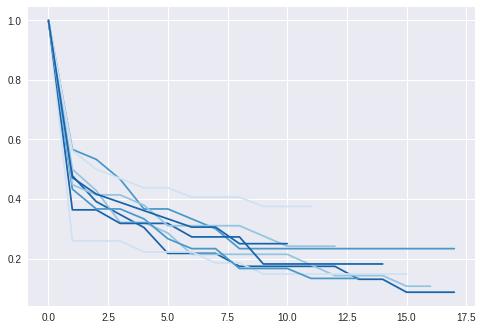

In [103]:
import seaborn as sns

fig, ax = plt.subplots()
seq_col_brew = sns.color_palette("Blues_r", 4)
sns.set_palette(seq_col_brew)


for i in range(0, len(user_retention.columns)):
    plt.plot(user_retention[user_retention.columns[i]])

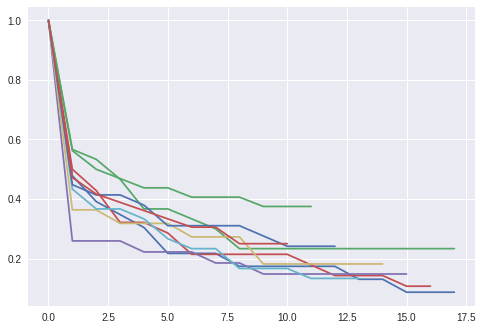

In [50]:
plt.plot(user_retention);

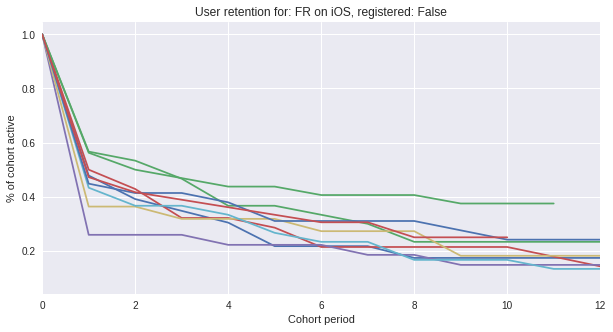

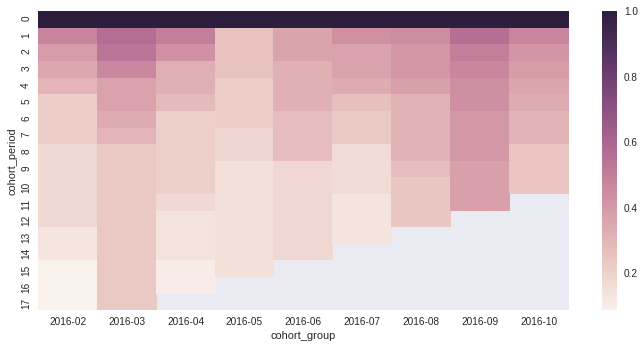

In [47]:
user_retention = func_cohort_analysis(country=country_values[2], platform=platform_values[1], user_registered=user_registered_values[0])

In [50]:
interact(func_cohort_analysis, Country=country_values , Platform=platform_values, User_registered=user_registered_values);

In [231]:
def func_cohort_analysis(Country, Platform, User_registered):
    
    # rewrite everything in the upper
    df = user_events_df.copy()
    # convert again to be able to plot it with no monthly params ('%Y-%m')
    
    df['Date'] = pd.to_datetime(df['Date'])
    # to_month = lambda x: x.strftime('%Y-%m')
    # df['Month'] = df['Month'].apply(to_month)

    
    # for each categorical (segmentation) feature
    if Country != 'All countries':
        df = df[df['Country'] == Country]
        
    if Channel != 'All platforms':
        df = df[df['platform'] == Platform]
        
    if Channel != 'All users':
        df = df[df['user_registered'] == Registered]

    # groupdf = df[['Store Listing Visitors', 'Installers', 'Date']].groupby('Date').sum()
    # groupdf['Conversion'] = groupdf['Installers'] / groupdf['Store Listing Visitors']
    # y_lim = groupdf['Store Listing Visitors'].max() * 1.25
    
    
    # visualization
    
    
    user_retention.plot(figsize=(15,10), colormap='Blues');
    
    """
    p = figure(width=600,
               height=400,
               x_axis_type='datetime',
               y_range=(0, y_lim),
               x_axis_label = 'Month',
               y_axis_label = 'Store Listing Visitors / Installers',
              title='Play Store Conversion: Store Listing Visitors to Installers')

    # plot views / installs
    p.vbar(x=groupdf.index, width=5000, bottom=0,
           top=groupdf['Store Listing Visitors'], color='#0074CD')
    p.vbar(x=groupdf.index + datetime.timedelta(days=1), width=10, bottom=0,
            top=groupdf['Installers'], color='green')
    
    # plot conversion
    
    p.extra_y_ranges = {"Conversion": Range1d(start=0, end=100)}
    p.add_layout(LinearAxis(y_range_name='Conversion', axis_label='Conversion'), 'right')
        
    p.line(x=groupdf.index, y=groupdf['Conversion']*100, line_width=2, y_range_name="Conversion", color='red')

    show(p)
    
    return groupdf
    
    """

In [59]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def f(n):
    plt.plot([0,1,2],[0,1,n])
    plt.show()
interact(f,n=(0,10));

In [75]:
user_events_df = df.copy()
user_events_df['sum'] = user_events_df['feature1'] + user_events_df['feature2'] + user_events_df['feature3']
user_events_df['date'] = pd.to_datetime(user_events_df['date'])

In [76]:
user_events_df = pd.DataFrame.from_csv('generating_user_behavioral_data.csv')

In [77]:
user_events_df.head()

,device_uuid,date,feature1,feature2,feature3,country,platform,user_registered
0,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-09-01,13,10.4,7.8,AU,iOS,False
1,e8aa1b74-b67b-4af7-8c3d-87b6f8382fa0,2016-04-01,2,1.6,1.2,FR,Android,False
2,14353987-d52a-4a9d-a837-4df6a86fe1b1,2016-09-01,7,5.6,4.2,AU,Android,True
3,14353987-d52a-4a9d-a837-4df6a86fe1b1,2016-10-01,11,8.8,6.6,AU,Android,True
4,14353987-d52a-4a9d-a837-4df6a86fe1b1,2016-11-01,5,4.0,3.0,AU,Android,True


In [78]:
user_events_df['sum'] = user_events_df['feature1'] + user_events_df['feature2'] + user_events_df['feature3']
user_events_df['date'] = pd.to_datetime(user_events_df['date'])

In [79]:
to_month = lambda x: x.strftime('%Y-%m')
user_events_df['onboarded_period'] = user_events_df['date'].apply(to_month)

In [80]:
user_events_df.set_index('device_uuid', inplace=True)
user_events_df['cohort_group'] = user_events_df.groupby(level=0)['date'].min().apply(lambda x:  x.strftime('%Y-%m'))
user_events_df.reset_index(inplace=True)
user_events_df.head()

,device_uuid,date,feature1,feature2,feature3,country,platform,user_registered,sum,onboarded_period,cohort_group
0,176b4011-c2f6-4007-9e03-6eecb93d5982,2016-09-01,13,10.4,7.8,AU,iOS,False,31.2,2016-09,2016-09
1,e8aa1b74-b67b-4af7-8c3d-87b6f8382fa0,2016-04-01,2,1.6,1.2,FR,Android,False,4.8,2016-04,2016-04
2,14353987-d52a-4a9d-a837-4df6a86fe1b1,2016-09-01,7,5.6,4.2,AU,Android,True,16.8,2016-09,2016-09
3,14353987-d52a-4a9d-a837-4df6a86fe1b1,2016-10-01,11,8.8,6.6,AU,Android,True,26.4,2016-10,2016-09
4,14353987-d52a-4a9d-a837-4df6a86fe1b1,2016-11-01,5,4.0,3.0,AU,Android,True,12.0,2016-11,2016-09


In [81]:
grouped = user_events_df.groupby(['cohort_group', 'onboarded_period'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'device_uuid': pd.Series.nunique,
                      'sum': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'device_uuid': 'all_users',
                       'sum': 'all_num_events'}, inplace=True)

cohorts.head()

all_users  all_num_events
cohort_group onboarded_period                           
2016-02      2016-02                  99          1737.6
             2016-03                  55           900.0
             2016-04                  50           840.0
             2016-05                  46           818.4
             2016-06                  46           736.8

In [82]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    
    df['cohort_period'] = np.arange(len(df)) + 0
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

all_users  all_num_events  cohort_period
cohort_group onboarded_period                                          
2016-02      2016-02                  99          1737.6              0
             2016-03                  55           900.0              1
             2016-04                  50           840.0              2
             2016-05                  46           818.4              3
             2016-06                  46           736.8              4

In [20]:
# reindex the dataframe
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group', 'cohort_period'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['all_users'].groupby(level=0).first()
cohort_group_size.head()

cohort_group
2016-02     99
2016-03    119
2016-04    115
2016-05    117
2016-06    106
Name: all_users, dtype: int64

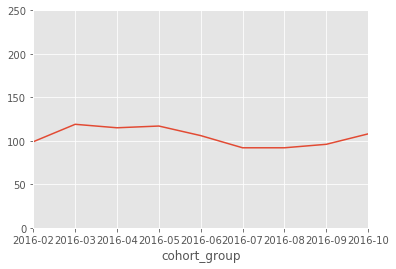

In [21]:
cohort_group_size.plot(kind='line', ylim=(0,250));

In [22]:
cohorts['all_users'].head()

cohort_group  cohort_period
2016-02       0                99
              1                55
              2                50
              3                46
              4                46
Name: all_users, dtype: int64

In [23]:
cohorts['all_users'].unstack(0).head()

cohort_group,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,
0,99.0,119.0,115.0,117.0,106.0,92.0,92.0,96.0,108.0
1,55.0,62.0,54.0,47.0,51.0,46.0,39.0,46.0,55.0
2,50.0,58.0,48.0,43.0,50.0,43.0,38.0,39.0,53.0
3,46.0,54.0,48.0,42.0,47.0,38.0,33.0,37.0,50.0
4,46.0,50.0,45.0,37.0,46.0,36.0,29.0,30.0,46.0


In [24]:
user_retention = cohorts['all_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

cohort_group,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.555556,0.521008,0.469565,0.401709,0.481132,0.500000,0.423913,0.479167,0.509259
2,0.505051,0.487395,0.417391,0.367521,0.471698,0.467391,0.413043,0.406250,0.490741
3,0.464646,0.453782,0.417391,0.358974,0.443396,0.413043,0.358696,0.385417,0.462963
4,0.464646,0.420168,0.391304,0.316239,0.433962,0.391304,0.315217,0.312500,0.425926
5,0.454545,0.394958,0.339130,0.299145,0.386792,0.347826,0.304348,0.270833,0.370370
6,0.444444,0.361345,0.330435,0.290598,0.367925,0.336957,0.293478,0.270833,0.351852
7,0.434343,0.336134,0.304348,0.264957,0.349057,0.336957,0.260870,0.208333,0.314815
8,0.414141,0.294118,0.286957,0.247863,0.330189,0.315217,0.239130,0.197917,0.287037


In [25]:
user_retention = user_retention.dropna(axis=1, how='all')
user_retention

cohort_group,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.555556,0.521008,0.469565,0.401709,0.481132,0.500000,0.423913,0.479167,0.509259
2,0.505051,0.487395,0.417391,0.367521,0.471698,0.467391,0.413043,0.406250,0.490741
3,0.464646,0.453782,0.417391,0.358974,0.443396,0.413043,0.358696,0.385417,0.462963
4,0.464646,0.420168,0.391304,0.316239,0.433962,0.391304,0.315217,0.312500,0.425926
5,0.454545,0.394958,0.339130,0.299145,0.386792,0.347826,0.304348,0.270833,0.370370
6,0.444444,0.361345,0.330435,0.290598,0.367925,0.336957,0.293478,0.270833,0.351852
7,0.434343,0.336134,0.304348,0.264957,0.349057,0.336957,0.260870,0.208333,0.314815
8,0.414141,0.294118,0.286957,0.247863,0.330189,0.315217,0.239130,0.197917,0.287037


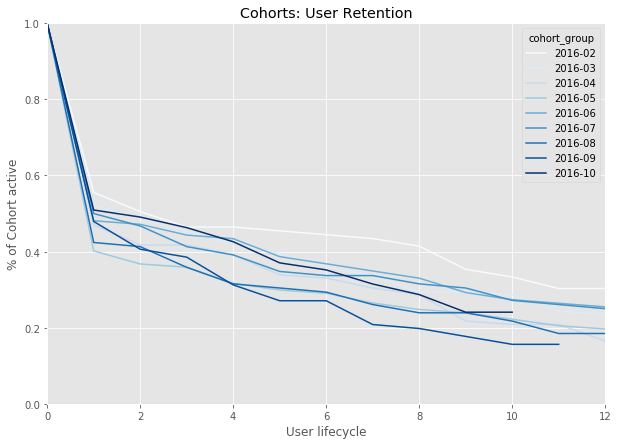

In [26]:

# user_retention.plot(figsize=(10,5))
# plt.title('Easy as 1, 2, 3')
# plt.title('Cohorts: User Retention')
# plt.xticks(np.arange(0, 12.1, 1))
# plt.xlim(0, 12)
# plt.ylabel('% of Cohort active');


#fig = Figure()
#ax = fig.add_subplot(111)
# ax.set_xlabel("% of Cohort active")
# ax.set_ylabel("Force (N)")

ax = user_retention.plot(figsize=(10,7), colormap='Blues', title='Cohorts: User Retention', xlim = (0, 12), ylim=(0,1));
ax.set_xlabel("User lifecycle")
ax.set_ylabel("% of Cohort active");

In [27]:
from bokeh.plotting import figure, output_notebook, show
output_notebook()

Loading BokehJS ...

In [28]:
p = figure(plot_width=400, plot_height=400)

# add a line renderer
p.line([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], line_width=2)

show(p)

In [30]:
def f(x,y):
    return x, y

In [31]:
interact(f, x=10, y=10);

In [32]:
platforms = ['All platforms', 'iOS', 'Android']
countries = ['All countries', 'NL', 'AU', 'FR']
user_registered = ['All', True, False]

In [33]:
def func_cohort_analysis(Country, Platform, User_registered):
    
    # rewrite everything in the upper
    df = user_events_df.copy()
    # convert again to be able to plot it with no monthly params ('%Y-%m')
    
    df['Date'] = pd.to_datetime(df['Date'])
    # to_month = lambda x: x.strftime('%Y-%m')
    # df['Month'] = df['Month'].apply(to_month)

    
    # for each categorical (segmentation) feature
    if Country != 'All countries':
        df = df[df['Country'] == Country]
        
    if Channel != 'All platforms':
        df = df[df['platform'] == Platform]
        
    if Channel != 'All users':
        df = df[df['user_registered'] == Registered]

    # groupdf = df[['Store Listing Visitors', 'Installers', 'Date']].groupby('Date').sum()
    # groupdf['Conversion'] = groupdf['Installers'] / groupdf['Store Listing Visitors']
    # y_lim = groupdf['Store Listing Visitors'].max() * 1.25
    
    
    # visualization
    
    
    user_retention.plot(figsize=(15,10), colormap='Blues');
    
    """
    p = figure(width=600,
               height=400,
               x_axis_type='datetime',
               y_range=(0, y_lim),
               x_axis_label = 'Month',
               y_axis_label = 'Store Listing Visitors / Installers',
              title='Play Store Conversion: Store Listing Visitors to Installers')

    # plot views / installs
    p.vbar(x=groupdf.index, width=5000, bottom=0,
           top=groupdf['Store Listing Visitors'], color='#0074CD')
    p.vbar(x=groupdf.index + datetime.timedelta(days=1), width=10, bottom=0,
            top=groupdf['Installers'], color='green')
    
    # plot conversion
    
    p.extra_y_ranges = {"Conversion": Range1d(start=0, end=100)}
    p.add_layout(LinearAxis(y_range_name='Conversion', axis_label='Conversion'), 'right')
        
    p.line(x=groupdf.index, y=groupdf['Conversion']*100, line_width=2, y_range_name="Conversion", color='red')

    show(p)
    
    return groupdf
    
    """

In [34]:
interact(func_cohort_analysis, Country=countries , Platform=platforms, Registered=user_registered);

ValueError: cannot find widget or abbreviation for argument: 'User_registered'

In [ ]:
user_retention.columns
user_retention.index

In [ ]:
user_retention.head()

In [ ]:
output_notebook()

In [ ]:
from bokeh.models import ColumnDataSource
import bokeh.plotting as bp

user_data_source = bp.ColumnDataSource(user_retention)

In [ ]:
user_retention[user_retention.columns[0]]

In [ ]:
# visualization
# https://stackoverflow.com/questions/36723684/purpose-of-columndatasource-in-bokeh


p = figure(width=600,
       height=400,
       # x_axis_type='datetime',
       # y_range=(0, y_lim),
       x_axis_label = 'Month',
       y_axis_label = 'Retention (%)',
      title='Product usage cohort analysis')

# plot retention

# p.line(x=user_retention.columns, y=user_retention.index, line_width=2, color='red')
p.line(source=user_data_source. x=user_retention[user_retention.columns[0]],
 y=user_retention[user_retention.columns[0]].index())

show(p)

In [ ]:
y1 = user_retention[user_retention.columns[0]].tolist()
y2 = user_retention[user_retention.columns[1]].tolist()
y3 = user_retention[user_retention.columns[2]].tolist()
y4 = user_retention[user_retention.columns[3]].tolist()
y5 = user_retention[user_retention.columns[4]].tolist()
y6 = user_retention[user_retention.columns[5]].tolist()
y7 = user_retention[user_retention.columns[6]].tolist()
y8 = user_retention[user_retention.columns[7]].tolist()
y9 = user_retention[user_retention.columns[8]].tolist()
y10 = user_retention[user_retention.columns[9]].tolist()

x = user_retention[user_retention.columns[0]].index.tolist()

In [ ]:
p = figure(plot_width=400, plot_height=400, x_axis_type="datetime")

p.multi_line([y1, x1], [y2, x1], [y3, x1], [y4, x1], [y5, x1], [y6, x1])

show(p)

In [ ]:
p = figure(plot_width=400, plot_height=400)

p.multi_line([[1, 3, 2], [3, 4, 6, 6]], [[2, 1, 4], [4, 7, 8, 5]],
             color=["firebrick", "navy"], alpha=[0.8, 0.3], line_width=4)

show(p)

In [ ]:
import pandas as pd
import bokeh.plotting as bp
from bokeh.models import HoverTool, DatetimeTickFormatter

# Create the base data
data_dict = {"Dates":["2017-03-01",
                  "2017-03-02",
                  "2017-03-03",
                  "2017-03-04",
                  "2017-03-05",
                  "2017-03-06"],
             "Prices":[1, 2, 1, 2, 1, 2]}

# Turn it into a dataframe
data = pd.DataFrame(data_dict, columns = ['Dates', 'Prices'])

# Convert the date column to the dateformat, and create a ToolTipDates column
data['Dates'] = pd.to_datetime(data['Dates'])
data['ToolTipDates'] = data.Dates.map(lambda x: x.strftime("%b %d")) # Saves work with the tooltip later

# Create a ColumnDataSource object
mySource = bp.ColumnDataSource(data)

# Create your plot as a bokeh.figure object
myPlot = bp.figure(height = 600,
               width = 800,
               x_axis_type = 'datetime',
               title = 'ColumnDataSource',
               y_range=(0,3))

# Format your x-axis as datetime.
myPlot.xaxis[0].formatter = DatetimeTickFormatter(days='%b %d')

# Draw the plot on your plot object, identifying the source as your Column Data Source object.
myPlot.circle("Dates",
          "Prices",
          source=mySource,
          color='red',
          size = 25)

# Add your tooltips
myPlot.add_tools( HoverTool(tooltips= [("Dates","@ToolTipDates"),
                                    ("Prices","@Prices")]))


# Create an output file
# bp.output_file('columnDataSource.html', title = 'ColumnDataSource')
bp.show(myPlot) # et voilà.

In [ ]:
mySource = bp.ColumnDataSource(data)

In [ ]:
type(source)